<a href="https://colab.research.google.com/github/Sravya0829/ExoplanetFinder/blob/main/Exoplanets3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Exoplanets

In this notebook, we'll continue improving our models for exoplanet classification!

We'll be:
*   Preprocessing the Dataset similar to before
*   Implementing more modern and complex machine learning architectures to see which one performs best!

## Exoplanet Classification




Previously, we were able to visualize and augment the dataset from Kepler. Now that we better understand the data that we're working with, we can begin to dive into more complex architectures to classify exoplanet stars, and the difficulties faced when doing so.

<font color=darkorange>**Change Hardware Accelerator to GPU to train faster (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)**


In [ ]:
#@title Run this code to get started
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv'

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import  metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling2D, BatchNormalization, MaxPooling1D
from keras.losses import categorical_crossentropy
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

df_train = pd.read_csv('exoTrain.csv')
df_train['LABEL'] = df_train['LABEL'] -1
df_test = pd.read_csv('exoTest.csv')
df_test['LABEL'] = df_test['LABEL'] - 1

def plot_graphs(history, best):

  plt.figure(figsize=[10,4])
  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy across training\n best accuracy of %.02f'%best[1])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss across training\n best loss of %.02f'%best[0])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def analyze_results(model, X_train, y_train, X_test, y_test):
    """
    Helper function to help interpret and model performance.

    Args:
    model: estimator instance
    X_train: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    y_train : array-like of shape (n_samples,)
    Target values for model training.
    X_test: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.
    y_test : array-like of shape (n_samples,)
    Target values for model testing.

    Returns:
    None
    """
    print("-------------------------------------------")
    print("Model Results")
    print("")
    print("Training:")
    if type(model) == keras.src.engine.sequential.Sequential:
      train_predictions = model.predict(X_train)
      train_predictions = (train_predictions > 0.5)
      cm = confusion_matrix(y_train, train_predictions)
      labels = [0, 1]
      df_cm = pd.DataFrame(cm,index = labels,columns = labels)
      fig = plt.figure()
      res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
      #plt.yticks([1.25, 3.75], labels,va='center')
      plt.title('Confusion Matrix - TestData')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
    else:
      plt.close()
      ConfusionMatrixDisplay.from_estimator(model,X_train,y_train)
      plt.show()

    print("Testing:")
    if type(model) == keras.src.engine.sequential.Sequential:
      test_predictions = model.predict(X_test)
      test_predictions = (test_predictions > 0.5)
      cm = confusion_matrix(y_test, test_predictions)
      labels = [0, 1]
      df_cm = pd.DataFrame(cm,index = labels,columns = labels)
      fig = plt.figure()
      res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
      #plt.yticks([1.25, 3.75], labels,va='center')
      plt.title('Confusion Matrix - TestData')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
    else:
      ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)

X_train = df_train.drop('LABEL', axis=1)
y_train = df_train['LABEL']
X_test = df_test.drop('LABEL', axis=1)
y_test = df_test['LABEL']

exoTrain.csv        100%[===================>] 250.08M  22.1MB/s    in 12s     
exoTest.csv         100%[===================>]  27.57M  14.1MB/s    in 1.9s    


Remember that `df_train` and `df_test` are the Pandas data frames that store our training and test datapoints. Similar to before, we'll now augment the data before exploring more modern, complex machine learning architectures.

In [ ]:
#@title Run this code to preprocess data
# Helper functions that we can run for the three augmentation functions that will be used, but not explroed in depth

def smote(a,b):
    model = SMOTE()
    X,y = model.fit_resample(a, b)
    return X,y

def savgol(df1,df2):
    x = savgol_filter(df1,21,4,deriv=0)
    y = savgol_filter(df2,21,4,deriv=0)
    return x,y

def fourier(df1,df2):
    X_train = np.abs(np.fft.fft(df1, axis=1))
    X_test = np.abs(np.fft.fft(df2, axis=1))
    return X_train,X_test

def norm(df1,df2):
    X_train = normalize(df1)
    X_test = normalize(df2)
    return X_train,X_test

def robust(df1,df2):
    scaler = RobustScaler()
    X_train = scaler.fit_transform(df1)
    X_test = scaler.transform(df2)
    return X_train,X_test

fourier_X_train, fourier_X_test = fourier(X_train, X_test)
savgol_X_train, savgol_X_test = savgol(fourier_X_train, fourier_X_test)
norm_X_train, norm_X_test = norm(savgol_X_train,savgol_X_test)
robust_X_train, robust_X_test = robust(norm_X_train, norm_X_test)
smote_X_train,smote_y_train = smote(robust_X_train, y_train)

# Here we're adding the generated, augmented data onto the testing data
# aug_X_train, new_X_test_data, aug_y_train, new_y_test_data = train_test_split(smote_X_train, smote_y_train, test_size=0.3)
# aug_X_test = np.concatenate((robust_X_test, new_X_test_data), axis=0)
# aug_y_test = np.concatenate((y_test, new_y_test_data), axis=0)

Awesome! Now we'll have access to the augmented dataset as `smote_X_train`, `robust_X_test`, `smote_y_train`, and `y_test`. Note that we only augmented our training data and kept the testing data only with pre-processing.

## Milestone 1: MLP

Let's start with neural nets!


![visual](https://s3.amazonaws.com/stackabuse/media/intro-to-neural-networks-scikit-learn-3.png)

#### Step 1: Create our model

Let's complete this by using an `MLPClassifier` model imported by the `sklearn` package.

In [ ]:
# Create an MLP model (will train later)

model = MLPClassifier(hidden_layer_sizes = (10,), random_state = 1, max_iter = 300) ### YOUR CODE HERE

Now, train the model using `smote_X_train` and `smote_y_train`, and analyze its accuracy and confusion matrix!

train accuracy:  0.9983168316831683
test accuracy:  0.9912280701754386
-------------------------------------------
Model Results

Training:


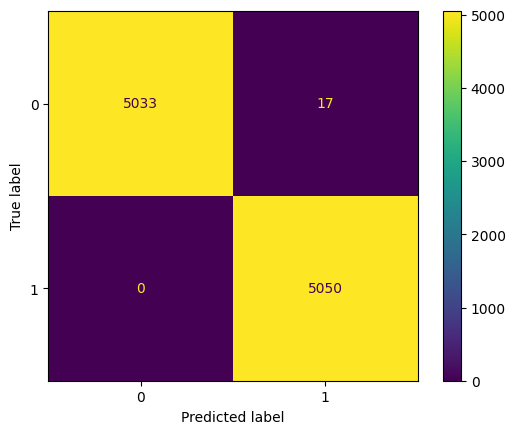

Testing:


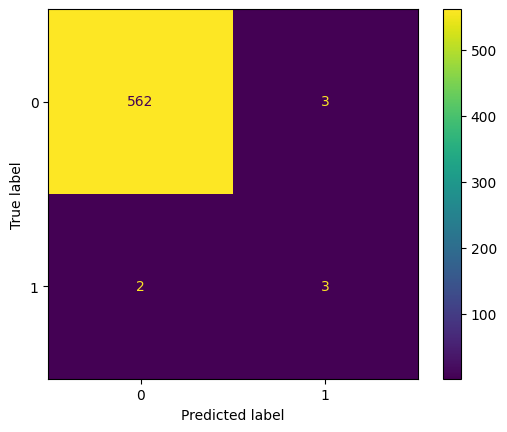

In [ ]:
### YOUR CODE HERE
model.fit(smote_X_train, smote_y_train)

train_pred = model.predict(smote_X_train)
print("train accuracy: ", accuracy_score(smote_y_train, train_pred))

test_pred = model.predict(robust_X_test)
print("test accuracy: ", accuracy_score(y_test, test_pred))

analyze_results(model, smote_X_train, smote_y_train, robust_X_test, y_test)

## Milestone 2: Neural Networks (Tensorflow and Keras)

Now let's do what we did before, but using `tensorflow` and `keras`.

We'll be using a `Sequential` model in order to act as a "list of layers", which we will define to match our previous example. Later, we'll use it to build more complex, advanced models.

In [ ]:
# Create a model (will train later)

# First, we initialize our model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(3197,)))
model.add(Dense(1, activation='sigmoid'))

#############

### YOUR CODE HERE

#############

# we finalize the model by "compiling" it and defining some other hyperparameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Now to check the details of your model, run the code block below.

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 10)                31980     
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31991 (124.96 KB)
Trainable params: 31991 (124.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
### YOUR CODE HERE to train the model
batch_size = 64
epochs = 20
verbose = 1
validation_data = (robust_X_test, y_test)
shuffle = True
history = model.fit(smote_X_train, smote_y_train, batch_size=batch_size, epochs=epochs, verbose=verbose,
                            validation_data=validation_data, shuffle=shuffle)
####################

Epoch 1/20
158/158 [==============================] - 7s 7ms/step - loss: 0.1636 - accuracy: 0.9403 - val_loss: 0.0590 - val_accuracy: 0.9860
Epoch 2/20
158/158 [==============================] - 1s 4ms/step - loss: 0.0398 - accuracy: 0.9884 - val_loss: 0.0497 - val_accuracy: 0.9842
Epoch 3/20
158/158 [==============================] - 1s 4ms/step - loss: 0.0227 - accuracy: 0.9943 - val_loss: 0.0478 - val_accuracy: 0.9895
Epoch 4/20
158/158 [==============================] - 1s 4ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.0684 - val_accuracy: 0.9860
Epoch 5/20
158/158 [==============================] - 1s 4ms/step - loss: 0.0219 - accuracy: 0.9917 - val_loss: 0.0565 - val_accuracy: 0.9877
Epoch 6/20
158/158 [==============================] - 1s 4ms/step - loss: 0.0240 - accuracy: 0.9920 - val_loss: 0.0547 - val_accuracy: 0.9912
Epoch 7/20
158/158 [==============================] - 1s 4ms/step - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.0566 - val_accuracy: 0.9930
Epoch 

Now we will see how to view the performance of the model as it trained over time!

In addition, we still want to be able to plot the confusion matrix of the model to check for performance and potential class biases. Enter code to analyze the model in the empty portion of the codeblock below.

9/9 [==============================] - 0s 3ms/step - loss: 0.0594 - accuracy: 0.9947


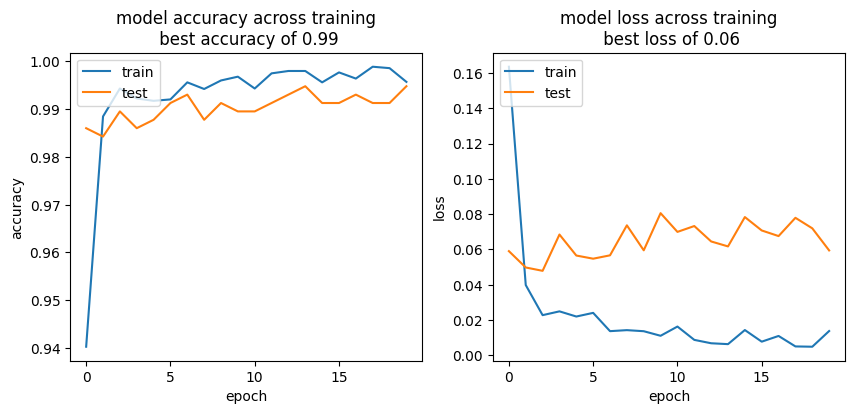

-------------------------------------------
Model Results

Training:
316/316 [==============================] - 1s 2ms/step


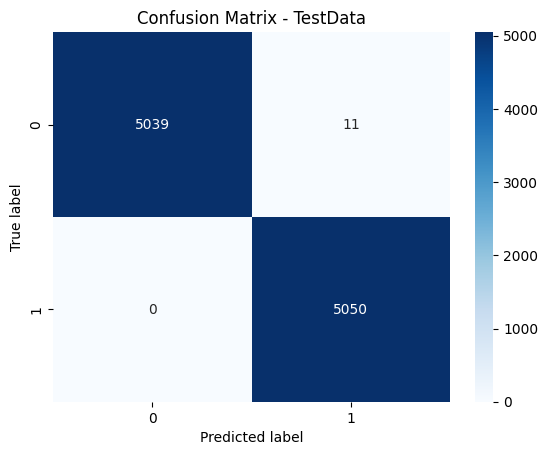

Testing:
18/18 [==============================] - 0s 2ms/step


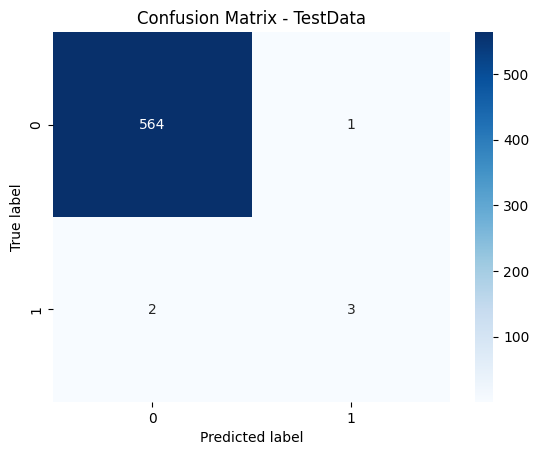

In [ ]:
performance = model.evaluate(robust_X_test, y_test, batch_size=batch_size)
plot_graphs(history, performance)

##############

### YOUR CODE HERE
analyze_results(model, smote_X_train, smote_y_train, robust_X_test, y_test)

##############